In [1]:
from datetime import datetime, timedelta
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

sys.path.append('..')
from utils.batcher import Batcher
#from util.stock_loader import Loader

In [2]:
TODAY = datetime.now().date()
TOMORROW  = TODAY + timedelta(1)
TOMORROW

datetime.date(2023, 2, 18)

In [3]:
DATA = '../data'

sp1950 = pd.read_csv(f'{DATA}/sp1950.csv')
nya1965 = pd.read_csv(f'{DATA}/nya1965.csv')
nasdaq1965 = pd.read_csv(f'{DATA}/nasdaq1965.csv')
wilshire1990 = pd.read_csv(f'{DATA}/wilshire1990.csv')


nasdaq1965.tail()
states = pd.read_csv(f'{DATA}/hmm_exp_returns.csv')
states.index = pd.to_datetime(states.Date)
states.tail()

,Date,^GSPC,^IXIC,^NYA,^W5000,^GSPC_returns,^NYA_returns,^IXIC_returns,^W5000_returns,^GSPC_exp,^NYA_exp,^IXIC_exp,^W5000_exp,mean_exp,state
Date,,,,,,,,,,,,,,,
2023-02-13,2023-02-13,4137.290039,11891.790039,16052.250000,41255.160156,1.011449,1.008897,1.014821,1.011394,0.999976,1.000669,1.000525,1.001307,1.000619,2
2023-02-14,2023-02-14,4136.129883,11960.150391,16025.110352,41292.578125,0.999720,0.998309,1.005749,1.000907,0.999976,1.000669,1.000525,1.001307,1.000619,2
2023-02-15,2023-02-15,4147.600098,12070.589844,16016.089844,41490.019531,1.002773,0.999437,1.009234,1.004782,0.999976,1.000669,1.000525,1.001307,1.000619,2
2023-02-16,2023-02-16,4090.409912,11855.830078,15873.780273,40938.761719,0.986211,0.991115,0.982208,0.986713,0.999976,1.000669,1.000525,1.001307,1.000619,2
2023-02-17,2023-02-17,4079.090088,11787.271484,15840.361328,40820.656250,0.997233,0.997895,0.994217,0.997115,0.999976,1.000669,1.000525,1.001307,1.000619,2


In [4]:
SYMBOLS = [
    'AAPL', 'ABMD', 'ABNB', 'ACN', 'ADBE', 'ADYEY', 'AMD', 'AMGN',
    'AMZN', 'ANET', 'ASML', 'AXON', 'BYND', 'CHWY', 'CRWD',
    'DDOG', 'DGX', 'DIS', 'DOCS', 'DOCU', 'EDIT', 'ETSY',
    'FLGT', 'FTNT', 'GH', 'GMED', 'GOOG', 'IDXX', 'ISRG',
    'JD', 'KNSL', 'LRCX', 'LSPD', 'LULU', 'MA', 'MASI', 'MDB',
    'MELI', 'MNST', 'MSFT', 'MTCH', 'NET', 'NOW', 'NVCR', 'NVDA',
    'ODFL', 'OKTA', 'OPEN', 'PAC', 'PANW', 'PAYC', 'PINS', 'PTON',
    'PYPL', 'QDEL', 'RBLX', 'RDFN', 'RGEN', 'RIVN', 'RMD', 'ROKU',
    'RVLV', 'SAM', 'SBUX', 'SE', 'SHOP', 'SNOW', 'TASK', 'TDOC',
    'TEAM', 'TMUS', 'TREX', 'TSCO', 'TSLA', 'TTC', 'TTD', 'TTWO',
    'TWLO', 'TYL', 'UPST', 'VEEV', 'VRTX', 'XPEV',
    'ZBRA', 'ZM']
LINGERERS = [
    'AGI', 'AMEH', 'APPS', 'BRTX', 'BROS', 'BTTR', 'BYRN',
    'CEF', 'CGAU', 'CPRX', 'CTGO', 'DQ', 'DTST', 'DUOL', 'EA', 'EP',
    'EPAM', 'EPSN',  'ESOA', 'FCUV', 'FNV', 'FSI', 'GCBC', 'GME',
    'GNRC', 'GTLS', 'HBM', 'HMY', 'IDR', 'INTG', 'INTZ', 'LPLA',
    'MCVT', 'MICS', 'MNMD', 'MOBQ', 'MTA', 'OMQS', 'PACB', 'PCRX',
    'POWW', 'PRPH', 'QLYS', 'RVP', 'RVYL', 'SAND', 'SPWR', 'STKL',
    'UI', 'VIRT', 'VLD', 'WAVD', 'WKHS', 'WRN', 'XPEV', 'ZEST',
    'ZYXI']
BEST_WEIGHTED =  [
    'AREN', 'BB', 'CHUY', 'CSIQ', 'CUBI', 'DYAI', 'FSM', 'LFMD',
    'LVS', 'OPNT', 'OSTK', 'PBF', 'PFIE', 'SBSW', 'SSTK',
    'URBN', 'VTSI', 'WYNN']
len(SYMBOLS + LINGERERS + BEST_WEIGHTED)

160

In [5]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
START, TODAY

(datetime.date(2013, 2, 20), datetime.date(2023, 2, 18))

In [6]:
batch = sorted(list(set(SYMBOLS + LINGERERS + BEST_WEIGHTED)))

In [7]:
data = (
    yf
    .download(batch, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'})
    .sort_index())

[*********************100%***********************]  159 of 159 completed


In [8]:
data['state'] = states.state
data.tail()

AdjClose                                                         \
                  AAPL ABMD        ABNB         ACN        ADBE  ADYEY    AGI   
Date                                                                            
2023-02-13  153.850006  NaN  116.419998  288.350006  375.000000  14.53  10.53   
2023-02-14  153.199997  NaN  120.870003  284.769989  377.899994  14.78  10.56   
2023-02-15  155.330002  NaN  137.009995  287.649994  375.940002  15.23  10.36   
2023-02-16  153.710007  NaN  139.419998  281.220001  365.160004  15.40  10.43   
2023-02-17  152.550003  NaN  131.600006  277.049988  356.850006  15.70  10.35   

                                              ...  Volume                   \
                  AMD       AMEH        AMGN  ...    WAVD     WKHS     WRN   
Date                                          ...                            
2023-02-13  83.129997  34.860001  241.530014  ...   62100  1950000  174600   
2023-02-14  85.949997  35.099998  241.029999  ...   61700  2223300  137300   
2023-02-15  85.180000  35.029999  240.070007  ...   81000  3132500  140700   
2023-02-16  80.080002  34.810001  234.220001  ...  109700  2883900  135700   
2023-02-17  78.500000  34.459999  240.529999  ...  122613  1853124   79847   

                                                                    state  
               WYNN        XPEV    ZBRA     ZEST         ZM    ZYXI        
Date                                                                       
2023-02-13  2468300   9916600.0  287500  1639500  2941300.0  214400     2  
2023-02-14  1991300   9826100.0  192600   580600  3308600.0  143200     2  
2023-02-15  1766700  11292700.0  305600   475000  2338400.0  133900     2  
2023-02-16  2026300  13636800.0  555800   363200  3205400.0  193700     2  
2023-02-17  2706000   8981579.0  493231   262075  2842898.0  167037     2  

[5 rows x 955 columns]

In [9]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5]

In [10]:
CURRENT_STATE = states.state[-1]
CURRENT_STATE

2

In [11]:
def get_stock_data(stock, data):
    sub = data.loc[
        :,  
        [x for x in list(data) if x[1] == stock]]
    first_value = (
        sub.AdjClose[stock][sub.AdjClose[stock].notna()].index[0])
    sub = sub.loc[first_value:, :]
    sub.columns = sub.columns.to_series().apply(lambda x: x[0])
    sub.fillna(method='ffill', inplace=True)
    return sub

In [12]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    #return x[2:n] / x[1:(n - 1)] - 1 
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [13]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [14]:
def get_hedged_sharpe(daily_returns, data):
    state_sharpe = get_sharpe(
        daily_returns[data.state == CURRENT_STATE])
    lower_state_sharpe = get_sharpe(
        daily_returns[data.state == max(CURRENT_STATE - 1, 0)])
    upper_state_sharpe = get_sharpe(
        daily_returns[
            data.state == min(CURRENT_STATE + 1, max(STATES))])
    return min(state_sharpe, lower_state_sharpe, upper_state_sharpe)

In [15]:
trans = pd.read_csv('../data/transition_probs.csv')
trans

,current_state,next_state,prob
0,2,0,0.028486
1,2,1,0.001325
2,2,2,0.942034
3,2,3,0.000331
4,2,4,0.000331
5,2,5,0.027493


In [16]:
def get_weighted_sharpe(daily_returns, data, trans=trans):
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #n_lower = (data.state == max(CURRENT_STATE - 1, 0)).sum()
    #decr = 1 if n_lower else 2
    #lower_state_sharpe = get_sharpe(
    #    daily_returns[data.state == max(CURRENT_STATE - decr, 0)])
    #n_upper = (data.state == max(CURRENT_STATE + 1, 0)).sum()
    #incr = 1 if n_lower else 2
    #upper_state_sharpe = get_sharpe(
    #    daily_returns[
    #        data.state == min(CURRENT_STATE + incr, max(STATES))])
    #return (
    #    weights[0]*lower_state_sharpe
    #    + weights[1]*state_sharpe
    #    + weights[2]*upper_state_sharpe)
    out = 0
    for state, prob in zip(trans.next_state, trans.prob):
        if len(daily_returns[data.state == state]):
            state_sharpe = get_sharpe(
                daily_returns[data.state == state])        
            out += prob * state_sharpe
    return out

In [17]:
def rescale(a):
    a = a - a.min()
    a = a / a.max()
    return a

In [18]:
def vals_to_quantiles(a):
    n = len(a)
    qs = np.linspace(0, 1, n)
    order = np.argsort(a)
    out = qs[order]
    return out

In [19]:
def get_rsi(stock_data, window=14):
    df = stock_data.copy()
    df['deltas'] = df.AdjClose.diff(1)
    df['gains'] = df.deltas.clip(lower=0)
    df['losses'] = df.deltas.clip(upper=0).abs()
    df['avg_gain'] = (df.gains
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    df['avg_loss'] = (df.losses
                      .rolling(window=window, min_periods=window)
                      .mean()[:window + 1])
    
    # avg gains
    pd.options.mode.chained_assignment = None
    for i, row in enumerate(df.avg_gain.iloc[window + 1:]):
        df.avg_gain.iloc[i + window + 1] = (
            (df.avg_gain.iloc[i + window] * (window - 1) 
             + df.gains.iloc[i + window + 1]) 
            / window)
    # avg losses
    for i, row in enumerate(df.avg_loss.iloc[window + 1:]):
        df.avg_loss.iloc[i + window + 1] = (
            (df.avg_loss.iloc[i + window] * (window - 1)
             + df.losses.iloc[i + window + 1])
            / window)
    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1. + df.rs))
    return df.rsi

In [20]:
def get_macd(stock_data, fast=60, slow=90, signal=80, plot=False):
    df = stock_data.copy()
    exp1 = df.AdjClose.ewm(span=fast, adjust=False).mean()
    exp2 = df.AdjClose.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    exp3 = macd.ewm(span=signal, adjust=False).mean()
    histo = macd - exp3
    hdiff = histo.diff(1)
    is_rising = 1 * (hdiff > 0)
    if plot:
        plt.plot(macd, label='MACD', color='red')
        plt.plot(exp3, label='Signal', color='green')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.legend();
        plt.figure()
        plt.plot(histo, color='blue')
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
        plt.axhline(y=0, color='k')
        plt.figure()
        plt.plot(is_rising)
        #plt.xlim(pd.to_datetime('2021-01-01'), 
        #         pd.to_datetime('2021-10-14'))
    return is_rising

In [21]:
LMB = 0.9
RSI_WINDOW = 14
MACD_PARAMS = (60, 90, 80, False)

In [22]:
EXAMPLE = 'AAPL'

In [23]:
stock_data = get_stock_data(EXAMPLE, data.copy())
daily_returns = get_daily_returns(stock_data.AdjClose)
daily_returns
(get_sharpe(daily_returns), 
 get_sharpe(daily_returns[data.state == CURRENT_STATE]))

(0.9799409527274159, 1.759481428210338)

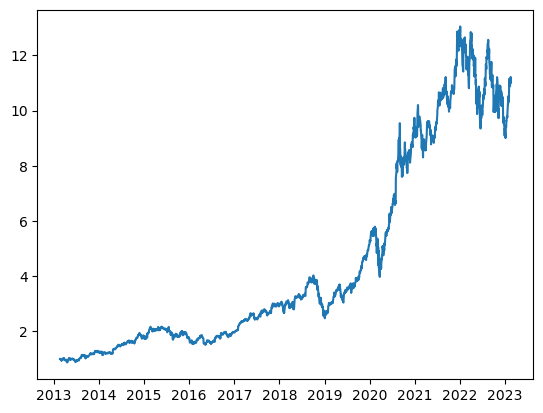

In [24]:
plt.plot(
    (get_daily_returns(data[('AdjClose', EXAMPLE)]) + 1).cumprod());

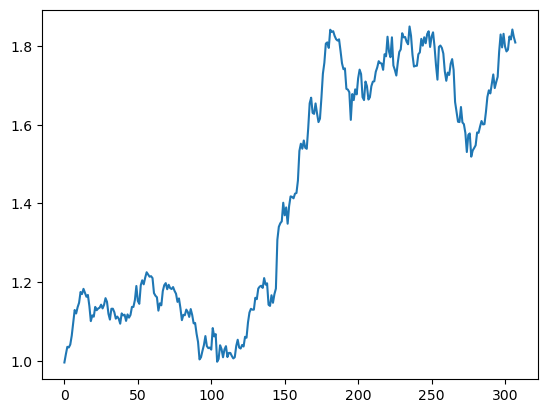

In [25]:
dr = get_daily_returns(
    data[('AdjClose', EXAMPLE)]
)[data.state == CURRENT_STATE]
dr = dr[dr.notnull()]
plt.plot((dr + 1).to_numpy().cumprod());

In [26]:
get_weighted_sharpe(daily_returns, data.copy())

1.5519495512483263

In [27]:
def process_stock(stock, data, lmb=LMB, plot=False):
    stock_data = get_stock_data(stock, data)
    n = len(stock_data.AdjClose[~np.isnan(stock_data.AdjClose)])
    stock_data['direction'] = get_macd(stock_data, *MACD_PARAMS)
    stock_data['rsi'] = get_rsi(stock_data, window=RSI_WINDOW)
    stock_data.rsi = stock_data.rsi.rank(pct=True)
    daily_returns = get_daily_returns(stock_data.AdjClose)
    sharpe = get_sharpe(daily_returns)
    #state_sharpe = get_sharpe(
    #    daily_returns[data.state == CURRENT_STATE])
    #hedged_sharpe = get_hedged_sharpe(daily_returns, data)
    weighted_sharpe = get_weighted_sharpe(daily_returns, data)
    stock_data.fillna(method='ffill', inplace=True)
    stock_data.fillna(method='bfill', inplace=True)
    WINDOW = min(n // 2, 125)
    stock_data['ann_high'] = (
        stock_data.AdjClose.rolling(window=WINDOW).max())
    stock_data['ann_low'] = (
        stock_data.AdjClose.rolling(window=WINDOW).min())
    stock_data['drawdown'] = stock_data.AdjClose / stock_data.ann_high
    stock_data.drawdown = stock_data.drawdown.rank(pct=True)
    stock_data['pullup'] = stock_data.AdjClose / stock_data.ann_low
    stock_data.pullup = stock_data.pullup.rank(pct=True)
    w = [lmb ** t for t in range(n)][::-1]
    stock_data['W'] = w
    stock_data['n_samp'] = (stock_data.Volume / 100)  * stock_data.W
    stock_data['value'] = (
        (stock_data.AdjClose 
         + stock_data.High 
         + stock_data.Low 
         + stock_data.Open) 
        / 4)
    stock_data['est'] = np.nan
    for day in stock_data.index:
        sub = stock_data[stock_data.index <= day]
        weights = sub.n_samp
        weights = weights / weights.sum()
        values = sub.value
        est = np.dot(weights, values)
        stock_data.loc[day, 'est'] = est
    stock_data['resid'] = stock_data.AdjClose / stock_data.est
    stock_data.resid = stock_data.resid.rank(pct=True)
    stock_data.sort_values('resid', inplace=True)
    #n_notnull_resid = stock_data.resid.notnull().sum()
    #stock_data['dev'] = np.nan
    #stock_data.loc[stock_data.resid.notnull(), 'dev'] = (
    #    np.array(range(n_notnull_resid) / n_notnull_resid))
    #stock_data.dev = stock_data.dev.rank(pct=True)
    stock_data.sort_index(inplace=True)
    if plot:
        plt.figure(figsize=(12, 8))
        plt.plot(stock_data.AdjClose, label='AdjClose')
        plt.plot(stock_data.est, label='Est')
        plt.yscale('log')
        plt.plot(stock_data.ann_high, color='green')
        plt.plot(stock_data.ann_low, color='red')
        plt.xlim([stock_data.index[-250], stock_data.index[-1]])
        plt.legend();
        
        #plt.figure(figsize=(12, 4))
        #plt.plot(stock_data.dev)
        #plt.axhline(0.5, color='k')
        #plt.xlim([stock_data.index[-250], stock_data.index[-1]])
        #plt.title(stock)
        
        plt.figure(figsize=(12, 4))
        plt.plot(stock_data.drawdown, color='red', label='drawdown')
        plt.plot(stock_data.pullup, color='green', label='pullup')
        plt.plot(
            np.sqrt(stock_data.drawdown * stock_data.pullup),
            color='grey',
            label='geomean')
        plt.yscale('log')
        plt.legend()
    return (
        stock_data.direction.tolist()[-1],  # keep
        stock_data.rsi.tolist()[-1],        # keep
        stock_data.resid.tolist()[-1],      # keep
        #stock_data.dev.tolist()[-1],        # drop
        stock_data.drawdown.tolist()[-1],   # keep
        stock_data.pullup.tolist()[-1],     # keep
        sharpe,                             # keep
        #state_sharpe,
        #hedged_sharpe,
        weighted_sharpe)                    # keep

(1,
 0.713258785942492,
 0.5874403815580286,
 0.7255639097744361,
 0.23433583959899748,
 0.9649618744505933,
 0.682500884916548)

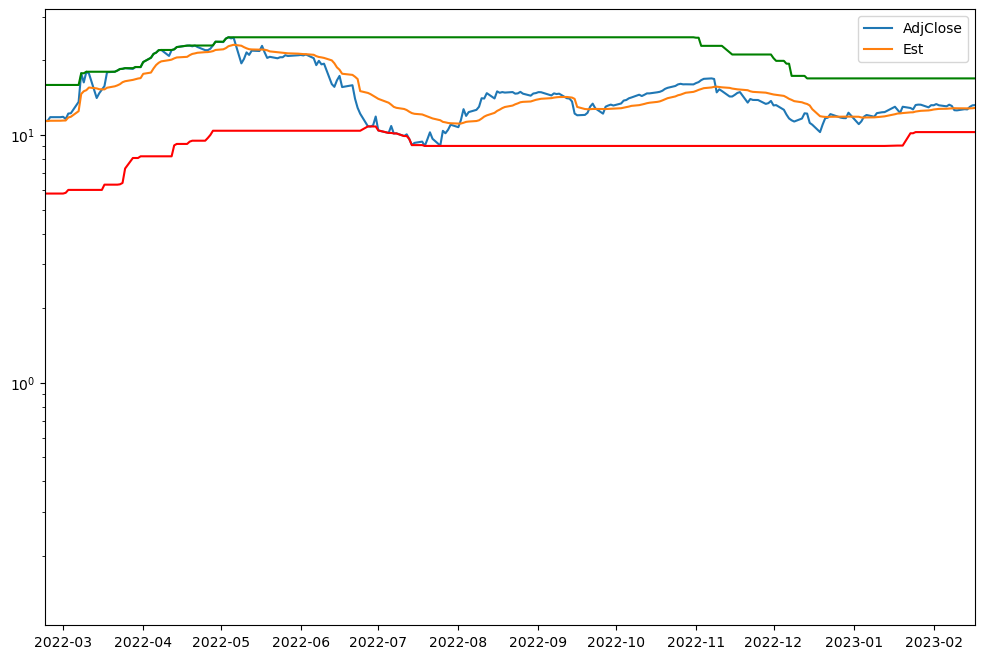

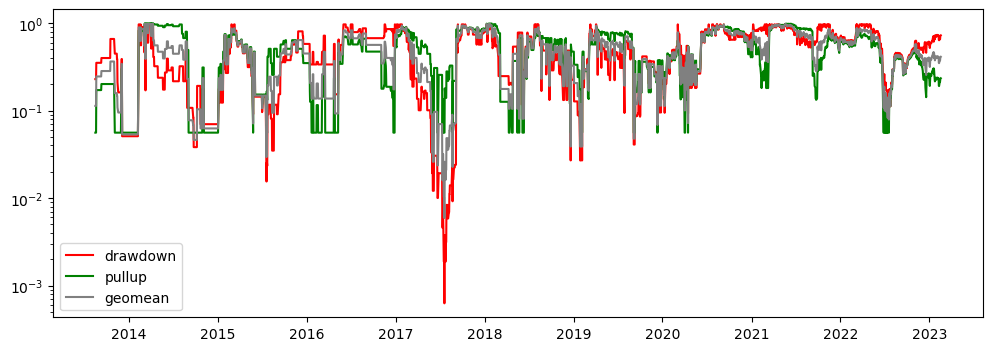

In [28]:
process_stock('EP', data.copy(), plot=True)

In [29]:
out = []
for stock in batch:
    print(f'{stock}...', end=' ')
    stock_stats = process_stock(stock, data)
    out.append([stock, *stock_stats])

AAPL... ABMD... ABNB... ACN... ADBE... ADYEY... AGI... AMD... AMEH... AMGN... AMZN... ANET... APPS... AREN... ASML... AXON... BB... BROS... BRTX... BTTR... BYND... BYRN... CEF... CGAU... CHUY... CHWY... CPRX... CRWD... CSIQ... CTGO... CUBI... DDOG... DGX... DIS... DOCS... DOCU... DQ... DTST... DUOL... DYAI... EA... EDIT... EP... EPAM... EPSN... ESOA... ETSY... FCUV... FLGT... FNV... FSI... FSM... FTNT... GCBC... GH... GME... GMED... GNRC... GOOG... GTLS... HBM... HMY... IDR... IDXX... INTG... INTZ... ISRG... JD... KNSL... LFMD... LPLA... LRCX... LSPD... LULU... LVS... MA... MASI... MCVT... MDB... MELI... MICS... MNMD... MNST... MOBQ... MSFT... MTA... MTCH... NET... NOW... NVCR... NVDA... ODFL... OKTA... OMQS... OPEN... OPNT... OSTK... PAC... PACB... PANW... PAYC... PBF... PCRX... PFIE... PINS... POWW... PRPH... PTON... PYPL... QDEL... QLYS... RBLX... RDFN... RGEN... RIVN... RMD... ROKU... RVLV... RVP... RVYL... SAM... SAND... SBSW... SBUX... SE... SHOP... SNOW... SPWR... SSTK... STKL..

In [30]:
out_df = pd.DataFrame(
    data=out, 
    columns=[
        'stock', 'direction', 'RSI', 'fair_value_mult',
        'drop','climb', 'sharpe', 'weighted_sharpe'])
out_df['geomean'] = np.sqrt(out_df['drop'] * out_df.climb)
out_df['score'] = (
    out_df.fair_value_mult
    * out_df['drop']
    * out_df.climb) ** (1/4) 
out_df['RSIRev'] = 1 - out_df.RSI
out_df = out_df[
    ['stock', 'direction', 'RSI', 'RSIRev', 'fair_value_mult', 
     'drop', 'climb', 'geomean', 'score',  'sharpe',
     'weighted_sharpe']]
out_df.RSI.fillna(out_df.RSI.median())
out_df.RSIRev.fillna(out_df.RSIRev.median())

out_df.weighted_sharpe.fillna(
    out_df.weighted_sharpe.mean(), inplace=True)
out_df.sort_values('stock')
out_df.head()

,stock,direction,RSI,RSIRev,fair_value_mult,drop,climb,geomean,score,sharpe,weighted_sharpe
0,AAPL,1,0.650958,0.349042,0.893963,0.304511,0.462406,0.375244,0.595644,0.979941,1.551950
1,ABMD,0,0.915136,0.084864,0.398928,0.889933,0.764202,0.824675,0.721714,0.944635,0.750606
2,ABNB,1,0.932961,0.067039,0.807623,0.925059,0.995316,0.959545,0.928613,0.213533,2.068818
3,ACN,0,0.237220,0.762780,0.772836,0.175021,0.338764,0.243497,0.462667,0.739953,1.124990
4,ADBE,0,0.188898,0.811102,0.101668,0.172932,0.675856,0.341873,0.330163,0.860536,0.276409


In [31]:
out_df.geomean.quantile([0.05, 0.99])

0.05    0.101620
0.99    0.939488
Name: geomean, dtype: float64

In [32]:
out_df.to_csv('individ_quantiles.csv', index=False)

In [33]:
!open individ_quantiles.csv